# Kernel Quadratures


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys, os
from pyprojroot import here
from wandb.sdk import wandb_config

# spyder up to find the root
root = here(project_files=[".here", ".env"])
# append to path
sys.path.append(str(root))

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

print(Path.cwd(), root)

/home/emmanuel/code/jax_kern/notebooks/uncategorized/kernels /home/emmanuel/code/jax_kern


## Toy Data

In [117]:
import jax
import jax.random as jr
import jax.numpy as jnp

seed = 123
key = jr.PRNGKey(seed)

ntrain = 60
ntest = 1_000

f = lambda x: jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + 0.5 * x))

X = jnp.linspace(-10, 10, ntrain).reshape(-1, 1)
X_cov = jnp.array([0.1]).reshape(-1, 1)

key, y_rng = jr.split(key, 2)
y = f(X)


Xtest = jnp.linspace(-10.1, 10.1, ntest).reshape(-1, 1)

## GP Model

In [118]:
from gpjax.gps import Prior
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian
from gpjax.types import Dataset
from gpjax.parameters import initialise

In [119]:
# GP Prior
mean_function = Zero()
kernel = RBF()
prior = Prior(mean_function=mean_function, kernel=kernel)

# GP Likelihood
lik = Gaussian()

# GP Posterior
posterior = prior * lik

# initialize training dataset
training_ds = Dataset(X=X, y=y)

In [120]:
# initialize parameters
params = initialise(posterior)

params = {"obs_noise": 0.003321, "lengthscale": 1.849, "variance": 0.9014}

## Predictions

In [121]:
from gpjax import mean, variance

meanf = mean(posterior, params, training_ds)
covarf = variance(posterior, params, training_ds)
varf = lambda x: jnp.atleast_1d(jnp.diag(covarf(x)))


mu = meanf(Xtest).squeeze()
var = varf(Xtest).squeeze()

In [122]:
n_features = 1


xtest_sample = Xtest[0]
xtrain_sample = X[0]

xtest_sample = jnp.atleast_1d(xtest_sample)
xtrain_sample = jnp.atleast_1d(xtrain_sample)

### Moment Transform

In [179]:
from jaxkern.gp.uncertain.mcmc import MCMomentTransform
from jaxkern.gp.uncertain.unscented import UnscentedTransform, SphericalRadialTransform
from jaxkern.gp.uncertain.quadrature import GaussHermite

# mm_transform = MCMomentTransform(n_features=1, n_samples=1_000, seed=123)
# mm_transform = UnscentedTransform(n_features=1, alpha=1.0, beta=2.0, kappa=None)
# mm_transform = GaussHermite(n_features=1, degree=20)
mm_transform = SphericalRadialTransform(n_features=1)

## Mean Expectations

In [180]:
from typing import Callable, Dict


def e_Mx(mean: Callable, mm_transform: Callable) -> Callable:
    def body(x):
        # calculate kernel
        y_mu = mean(x).squeeze()

        # ensure size
        y_mu = jnp.atleast_1d(y_mu)

        return y_mu

    def f(key, x, x_cov):

        x_mu = mm_transform.mean(body, x, x_cov)

        return x_mu

    return f

In [181]:
# initialize function
f = e_Mx(meanf, mm_transform,)

y_mu = f(key, xtest_sample, X_cov)


chex.assert_shape(y_mu, (n_features,))

In [182]:
f = e_Mx(meanf, mm_transform,)


f = jax.jit(jax.vmap(f, in_axes=(None, 0, None)))

In [183]:
%%time

y_mu = f(key, Xtest.block_until_ready(), X_cov.block_until_ready())

chex.assert_shape(y_mu, (ntest, n_features,))

CPU times: user 90.2 ms, sys: 2.63 ms, total: 92.8 ms
Wall time: 87.3 ms


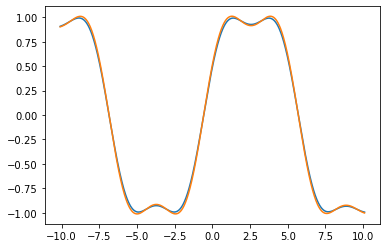

In [184]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(Xtest, y_mu)
plt.plot(Xtest, mu)

## Kernel Expectations

#### Kernel Expectation - $\Psi_0$

#### Univariate

$$
\psi_{0_i} = \left\langle k(\mathbf{x}_i, \mathbf{x}_i) \right\rangle_{p(\mathbf{x}_i)}
$$

In [185]:
import chex

n_features = 1

f = lambda x: jnp.atleast_1d(kernel(x, x, params))

t = f(xtest_sample)


chex.assert_shape(t, (n_features,))

$$
\psi_{0} = \sum_{i=1}^N\left\langle k(\mathbf{x}_i, \mathbf{x}_i) \right\rangle_{p(\mathbf{x}_i)}
$$

In [186]:
from typing import Callable, Dict


def e_kx(kernel: Callable, params: Dict, mm_transform: Callable) -> Callable:
    def body(x):
        # calculate kernel
        kx = kernel(x, x, params)

        # ensure size
        kx = jnp.atleast_1d(kx)

        return kx

    def f(key, x, x_cov):

        x_mu = mm_transform.mean(body, x, x_cov)

        return x_mu

    return f

In [187]:
# initialize function
f = e_kx(kernel, params, mm_transform,)

kx_mu = f(key, xtest_sample, X_cov)


chex.assert_shape(kx_mu, (n_features,))

##### Vectorize Batch Dimension

In [188]:
f = e_kx(kernel, params, mm_transform,)


f = jax.jit(jax.vmap(f, in_axes=(None, 0, None)))

In [189]:
%%time

Kx_mu = f(key, Xtest.block_until_ready(), X_cov.block_until_ready())

chex.assert_shape(Kx_mu, (ntest, n_features,))

CPU times: user 52.5 ms, sys: 1.21 ms, total: 53.7 ms
Wall time: 51.4 ms


#### Kernel Expectation - $\Psi_1$


$$
\psi_{1} = \sum_{i=1}^N\left\langle k(\mathbf{x}_i, \mathbf{y}) \right\rangle_{p(\mathbf{x}_i)}
$$

In [190]:
kf = lambda x: jnp.atleast_1d(kernel(x, y, params))

kx_mu = mm_transform.mean(kf, xtest_sample, X_cov)

chex.assert_shape(kx_mu, (n_features,))

In [191]:
from chex import Array


def e_kxy(kernel: Callable, params: Dict, mm_transform: Callable) -> Callable:
    def body(y, x):
        # calculate kernel
        kxy = kernel(x, y, params)

        # ensure size
        kxy = jnp.atleast_1d(kxy)

        return kxy

    def f(x, x_cov, y):

        f = jax.partial(body, y)

        x_mu = mm_transform.mean(f, x, x_cov)

        return jnp.atleast_1d(x_mu)

    return f

In [192]:
# initialize function
f = e_kxy(kernel, params, mm_transform=mm_transform,)

kx_mu = f(xtest_sample, X_cov, xtrain_sample)


chex.assert_shape(kx_mu, (n_features,))

In [193]:
# initialize function
f = e_kxy(kernel, params, mm_transform=mm_transform)

mv = jax.vmap(f, in_axes=(0, None, None), out_axes=(0))
mm = jax.vmap(mv, in_axes=(None, None, 0), out_axes=(1))

mm = jax.jit(mm)

In [194]:
%%time

kx_mu = mm(Xtest, X_cov, X)[..., 0]


chex.assert_shape(kx_mu, (ntest, ntrain,))

CPU times: user 97.4 ms, sys: 7.74 ms, total: 105 ms
Wall time: 91.1 ms


#### Kernel Expectation - $\Psi_2$

In [195]:
from chex import Array


def e_kxykxz(
    kernel1: Callable,
    params1: Dict,
    kernel2: Callable,
    params2: Dict,
    mm_transform: Callable,
) -> Callable:
    def body(y, z, x):
        # calculate kernel
        kxy = kernel1(x, y, params1)

        kxz = kernel2(x, z, params2)

        kxykxz = kxy * kxz

        # ensure size
        kxy = jnp.atleast_1d(kxy)

        return kxy

    def f(x, x_cov, y, z):

        f = jax.partial(body, y, z)

        x_mu = mm_transform.mean(f, x, x_cov)

        return jnp.atleast_1d(x_mu)

    return f

In [196]:
# initialize function
f = e_kxykxz(kernel, params, kernel, params, mm_transform=mm_transform)

mvv = jax.vmap(f, in_axes=(0, None, None, None), out_axes=(0))
mmv = jax.vmap(mvv, in_axes=(None, None, 0, None), out_axes=(1))
mmm = jax.vmap(mmv, in_axes=(None, None, None, 0), out_axes=(2))
mmm = jax.jit(mmm)

In [198]:
%%time

kxykxz_mu = mmm(Xtest, X_cov, X, X[10:])[..., 0]


chex.assert_shape(kxykxz_mu, (ntest, ntrain, ntrain-10))

CPU times: user 25.1 ms, sys: 12 ms, total: 37.2 ms
Wall time: 8.02 ms
